# CIFAR10 Dataset Recognition using CNN 
###  → See Section 5 in Master Thesis : "Model prototype" 

## • Imports & preprocessing 

In [2]:
import time 
import numpy as np 
import sys
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation, GaussianNoise
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.constraints import maxnorm
from keras.utils import np_utils
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [3]:
# Set random seed for purposes of reproducibility
seed = 21

In [4]:
from keras.datasets import cifar10

In [5]:
# loading in the data
     
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print(y_train)

[[6]
 [9]
 [9]
 ...
 [9]
 [1]
 [1]]


In [5]:
# normalize the inputs from 0-255 to between 0 and 1 by dividing by 255
    
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0

### Sampling training dataset

In [6]:
# Sample by taking only the first batch of the dataset
X_train_bis = X_train[0:10000] 
y_train_bis = y_train[0:10000]

###  One hot encoding

In [7]:
# specify the number of classes that are in the dataset, so we know how many neurons to compress the final layer down to 
y_train_bis = np_utils.to_categorical(y_train_bis)
y_test = np_utils.to_categorical(y_test)
class_num = y_test.shape[1]

## • Creating the model

### Convolutional layers

In [8]:
# Create the model and add the first convolutional layer 
model = Sequential()

# Add weight decay => add kernel_regularizer=l2(0.01) as parameter and comment Dropout lines 
model.add(Conv2D(32, (3, 3), input_shape=X_train.shape[1:], padding='same',  kernel_regularizer=l2(0.001))) # 32 filters, window of 3x3 pixels
model.add(Activation('relu')) 

# It means that you randomly select 20% (if dropout = 0.2) of the neurons and set their weights to zero for the forward and backward passes i.e. for one iteration.
dropoutValue = 0.4
#model.add(Dropout(dropoutValue)) 

# Batch normalization
model.add(BatchNormalization())

# Repeat until 128 
model.add(Conv2D(64, (3, 3), padding='same',  kernel_regularizer=l2(0.001)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(GaussianNoise(0.4)) # add noise
#model.add(Dropout(dropoutValue))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(0.001)))
model.add(Activation('relu'))
#model.add(Dropout(dropoutValue))
model.add(BatchNormalization())

### Flatten

In [9]:
model.add(Flatten())
#model.add(Dropout(dropoutValue))

### Fully-connected layer (Dense layers)

In [10]:
model.add(Dense(256, kernel_constraint=maxnorm(3)))
model.add(Activation('relu'))
#model.add(Dropout(dropoutValue))
model.add(BatchNormalization())

model.add(Dense(128, kernel_constraint=maxnorm(3)))
model.add(Activation('relu'))
#model.add(Dropout(dropoutValue))
model.add(BatchNormalization())

# Last layer : 10 neurons representing 10 possible outputs 
model.add(Dense(class_num))
model.add(Activation('softmax'))

## • Model compilation

In [11]:
epochs = 5 
batch_size = 64
optimizer = 'adagrad'

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 64)        256       
__________

## • Data augmentation

<b>Note:</b> Uncomment this following cell to try some data augmentation and comment the cell "Model training" 

In [12]:
'''
# create data generator
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
# prepare iterator
it_train = datagen.flow(X_train, y_train, batch_size=64)
# fit model
steps = int(X_train.shape[0] / 64)
start_time = time.time()
history = model.fit_generator(it_train, steps_per_epoch=steps, epochs=epochs, validation_data=(X_test, y_test))
print("--- %s seconds ---" % (time.time() - start_time))
'''

'\n# create data generator\ndatagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)\n# prepare iterator\nit_train = datagen.flow(X_train, y_train, batch_size=64)\n# fit model\nsteps = int(X_train.shape[0] / 64)\nstart_time = time.time()\nhistory = model.fit_generator(it_train, steps_per_epoch=steps, epochs=epochs, validation_data=(X_test, y_test))\nprint("--- %s seconds ---" % (time.time() - start_time))\n'

## • Model training

In [13]:
np.random.seed(seed)
start_time = time.time()
history = model.fit(X_train_bis, y_train_bis, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size)
print("--- %s seconds ---" % (time.time() - start_time)) 

Train on 10000 samples, validate on 10000 samples
Epoch 1/5
10000/10000 [==============================] - 96s 10ms/step - loss: 1.6436 - acc: 0.4654 - val_loss: 1.4741 - val_acc: 0.5198
Epoch 2/5
10000/10000 [==============================] - 99s 10ms/step - loss: 1.1097 - acc: 0.6455 - val_loss: 1.3342 - val_acc: 0.5648
Epoch 3/5
10000/10000 [==============================] - 96s 10ms/step - loss: 0.7496 - acc: 0.7827 - val_loss: 1.3390 - val_acc: 0.5834
Epoch 4/5
10000/10000 [==============================] - 96s 10ms/step - loss: 0.4393 - acc: 0.9047 - val_loss: 1.3862 - val_acc: 0.5750
Epoch 5/5
10000/10000 [==============================] - 93s 9ms/step - loss: 0.2412 - acc: 0.9751 - val_loss: 1.2997 - val_acc: 0.6193
--- 480.30755376815796 seconds ---


## • Model evaluation

In [14]:
# Model evaluation
_, acc = model.evaluate(X_test, y_test)
print('accuracy > %.3f' % (acc * 100.0))

10000/10000 [==============================] - 16s 2ms/step
accuracy > 61.930


---------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------

## --- Results accuracy ---

<b> Note: </b> These tests are performed over 5 epochs. As we use sampling to avoid multiple large execution times, the results may be quite lower compared to if we have used the whole dataset. But these results are representatives and should respect proportions.  Nevertheless, concerning the regularizers, we also test with the whole dataset. 

#### Testing optimizers (baseline):
<i> With sampled dataset | Batch Size = 64 </i> 
- Optimizer RMSPROP : <b>54.640%</b>
- Optimizer ADAM : <b>61.220%</b>
- Optimizer SGD : <b>51.720%</b>
- Optimizer ADAGRAD : <font color="red"><b>63.490%</b></font> 
- Optimizer ADADELTA : <b>55.770%</b> 

### To counter overfitting : 
#### 1. Testing dropout values : 
<i> With sampled dataset | Batch Size = 64 | Optimizer ADAGRAD </i> 
- No dropout : <font color="red"><b>63.490%</b></font> 
- With dropout of 0.1 : <b>55.530%</b> 
- With dropout of 0.2 : <b>57.840%</b> 
- With dropout of 0.4 : <b>45.140%</b> 

<i> With the whole dataset | Batch Size = 64 | Optimizer ADAGRAD </i> 
- No dropout : <b>76.13%</b>
- With dropout of 0.1 : <b>76.51%</b> 
- With dropout of 0.2 : <b>78.140%</b> 
- With dropout of 0.4 : <b>59.890%</b> 

#### 2. Testing weight decay : 
<i> With sampled dataset | Batch Size = 64 | Optimizer ADAGRAD  </i> 
- No weight decay : <b>63.490%</b>
- With weight decay of 0.001 : <font color="red"><b>64.190%</b></font>
- With weight decay of 0.01 : <b>60.140%</b> 

<i> With the whole dataset | Batch Size = 64 | Optimizer ADAGRAD  </i> 
- No weight decay : <b>76.13%</b>
- With weight decay of 0.001 : <font color="red"><b>77.470%</b></font>
- With weight decay of 0.01 : <b>76.090%</b>


#### 3. Testing simple data augmentation : 
<i> With sampled dataset | Batch Size = 64 | Optimizer ADAGRAD  </i> 
- With horizontal flip, minor shifts of the image, and small zooming : <font color="red"><b>64.810%</b></font> 

<i> With the whole dataset | Batch Size = 64 | Optimizer ADAGRAD  </i> 
- With horizontal flip, minor shifts of the image, and small zooming : <font color="red"><b>78.410%</b></font>  

### Testing with noise added : 
<i> With sampled dataset | Batch Size = 64 | Optimizer ADAGRAD </i> 
- No noise : <b>63.490%</b>
- Gaussian noise of 0.1 : <font color="red"><b>64.760%</b></font> 
- Gaussian noise of 0.2 : <b>60.710%</b>
- Gaussian noise of 0.4 : <b>62.080%</b>

<i> With the whole dataset | Batch Size = 64 | Optimizer ADAGRAD </i> 
- No noise : <font color="red"><b>76.13%</b></font> 
- Gaussian noise of 0.1 : <b>75.520%</b>
- Gaussian noise of 0.2 : <b>75.960%</b>
- Gaussian noise of 0.4 : <b>75.230%</b>

### Testing epochs values : 

<i> On 40 epochs, Batch Size = 64 | No dropout | Optimizer ADAGRAD </i>

In [15]:
# plot diagnostic learning curves
def summarize_diagnostics_by_epochs(history):
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss --> https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

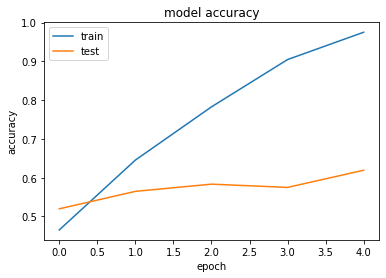

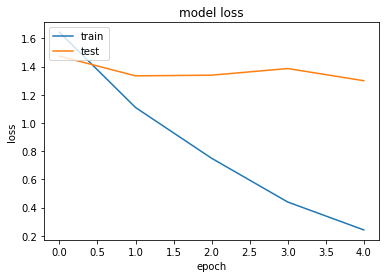

In [16]:
summarize_diagnostics_by_epochs(history)